# <p style="text-align: center;">Direct solver comparison in OGS</p>

## Machine: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz

## Model: ThermoRichardsMechanics (2D) 40 000 nodes 10 time steps

In [1]:
from ogs6py.ogs import OGS
import numpy as np
import matplotlib.pyplot as plt
import plot_settings

In [2]:
runs=2

In [3]:
folder= "/home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison"

In [4]:
solvers = ["PETSc/SuperLU", "PETSc/MUMPS", "PETSc/PardisoLU"]

In [5]:
omp_runs = [2,4]
mpi_runs = [2, 4]

In [6]:
def setSolverOMP(fileobject, solver):
    if solver == "PETSc/SuperLU":
        fileobject.replace_text("-pc_type lu -pc_factor_mat_solver_type superlu_dist -ksp_view", xpath="./linear_solvers/linear_solver/petsc/parameters")
        fileobject.write_input()
        fileobject.run_model(path="/home/buchwalj/github/ogs/build_mkl_petsc/bin", logfile=f"{folder}/superlu.out", wrapper="source /opt/intel/oneapi/setvars.sh intel64 &&")
    elif solver == "PETSc/MUMPS":
        fileobject.replace_text("-pc_type lu -pc_factor_mat_solver_type mumps -ksp_view", xpath="./linear_solvers/linear_solver/petsc/parameters")
        fileobject.write_input()
        fileobject.run_model(path="/home/buchwalj/github/ogs/build_mkl_petsc/bin", logfile=f"{folder}/mumps.out", wrapper="source /opt/intel/oneapi/setvars.sh intel64 &&")
    elif solver == "PETSc/PardisoLU":
        fileobject.replace_text("-pc_type lu -pc_factor_mat_solver_type mkl_pardiso -ksp_view", xpath="./linear_solvers/linear_solver/petsc/parameters")
        fileobject.write_input()
        fileobject.run_model(path="/home/buchwalj/github/ogs/build_mkl_petsc/bin", logfile=f"{folder}/pardiso.out", wrapper="source /opt/intel/oneapi/setvars.sh intel64 &&")
    exec_time = fileobject.exec_time
    return exec_time
def setSolverMPI(fileobject, solver, n_p):
    if solver == "PETSc/SuperLU":
        fileobject.replace_text("-pc_type lu -pc_factor_mat_solver_type superlu_dist -ksp_view", xpath="./linear_solvers/linear_solver/petsc/parameters")
        fileobject.write_input()
        fileobject.run_model(path="/home/buchwalj/github/ogs/build_mkl_petsc/bin", logfile=f"{folder}/superlu.out", wrapper=f"source /opt/intel/oneapi/setvars.sh intel64 && mpirun -np {n_p}")
    elif solver == "PETSc/MUMPS":
        fileobject.replace_text("-pc_type lu -pc_factor_mat_solver_type mumps -ksp_view", xpath="./linear_solvers/linear_solver/petsc/parameters")
        fileobject.write_input()
        fileobject.run_model(path="/home/buchwalj/github/ogs/build_mkl_petsc/bin", logfile=f"{folder}/mumps.out", wrapper=f"source /opt/intel/oneapi/setvars.sh intel64 && mpirun -np {n_p}")
    exec_time = fileobject.exec_time
    return exec_time

In [7]:
exec_time = {}
for solver in solvers:
    for n_p in omp_runs:
        exec_time[solver+"_OMP"+str(n_p)] = []
    for n_p in mpi_runs:
        if solver != "PETSc/PardisoLU":
            exec_time[solver+"_MPI"+str(n_p)] = []
    for i in range(runs):
        solver_ = solver.split("/")[-1]
        for n_p in omp_runs:
            m = OGS(INPUT_FILE=f"{folder}/Decovalex-0.prj", PROJECT_FILE=f"{folder}/{solver_}.prj", OMP_NUM_THREADS=n_p)
            exec_time[solver+"_OMP"+str(n_p)].append(setSolverOMP(m, solver))
        for n_p in mpi_runs:
            if solver != "PETSc/PardisoLU":
                m = OGS(INPUT_FILE=f"{folder}/Decovalex-0.prj", PROJECT_FILE=f"{folder}/{solver_}.prj", OMP_NUM_THREADS=1)
                exec_time[solver+"_MPI"+str(n_p)].append(setSolverMPI(m, solver,n_p))

OGS finished with project file /home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison/SuperLU.prj.
Execution took 31.616238355636597 s
OGS finished with project file /home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison/SuperLU.prj.
Execution took 36.66771650314331 s
OGS finished with project file /home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison/SuperLU.prj.
Execution took 27.611382246017456 s
OGS finished with project file /home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison/SuperLU.prj.
Execution took 26.573585987091064 s
OGS finished with project file /home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison/SuperLU.prj.
Execution took 34.067347288131714 s
OGS finished with project file /home/buchwalj/OGS_Solver_Comparison/data/sims/Petsc_direct_solver_comparison/SuperLU.prj.
Execution took 36.94365930557251 s
OGS finished with project file /home/buchwalj/OGS_Solv

In [8]:
solvers_ext = [item for item in exec_time]

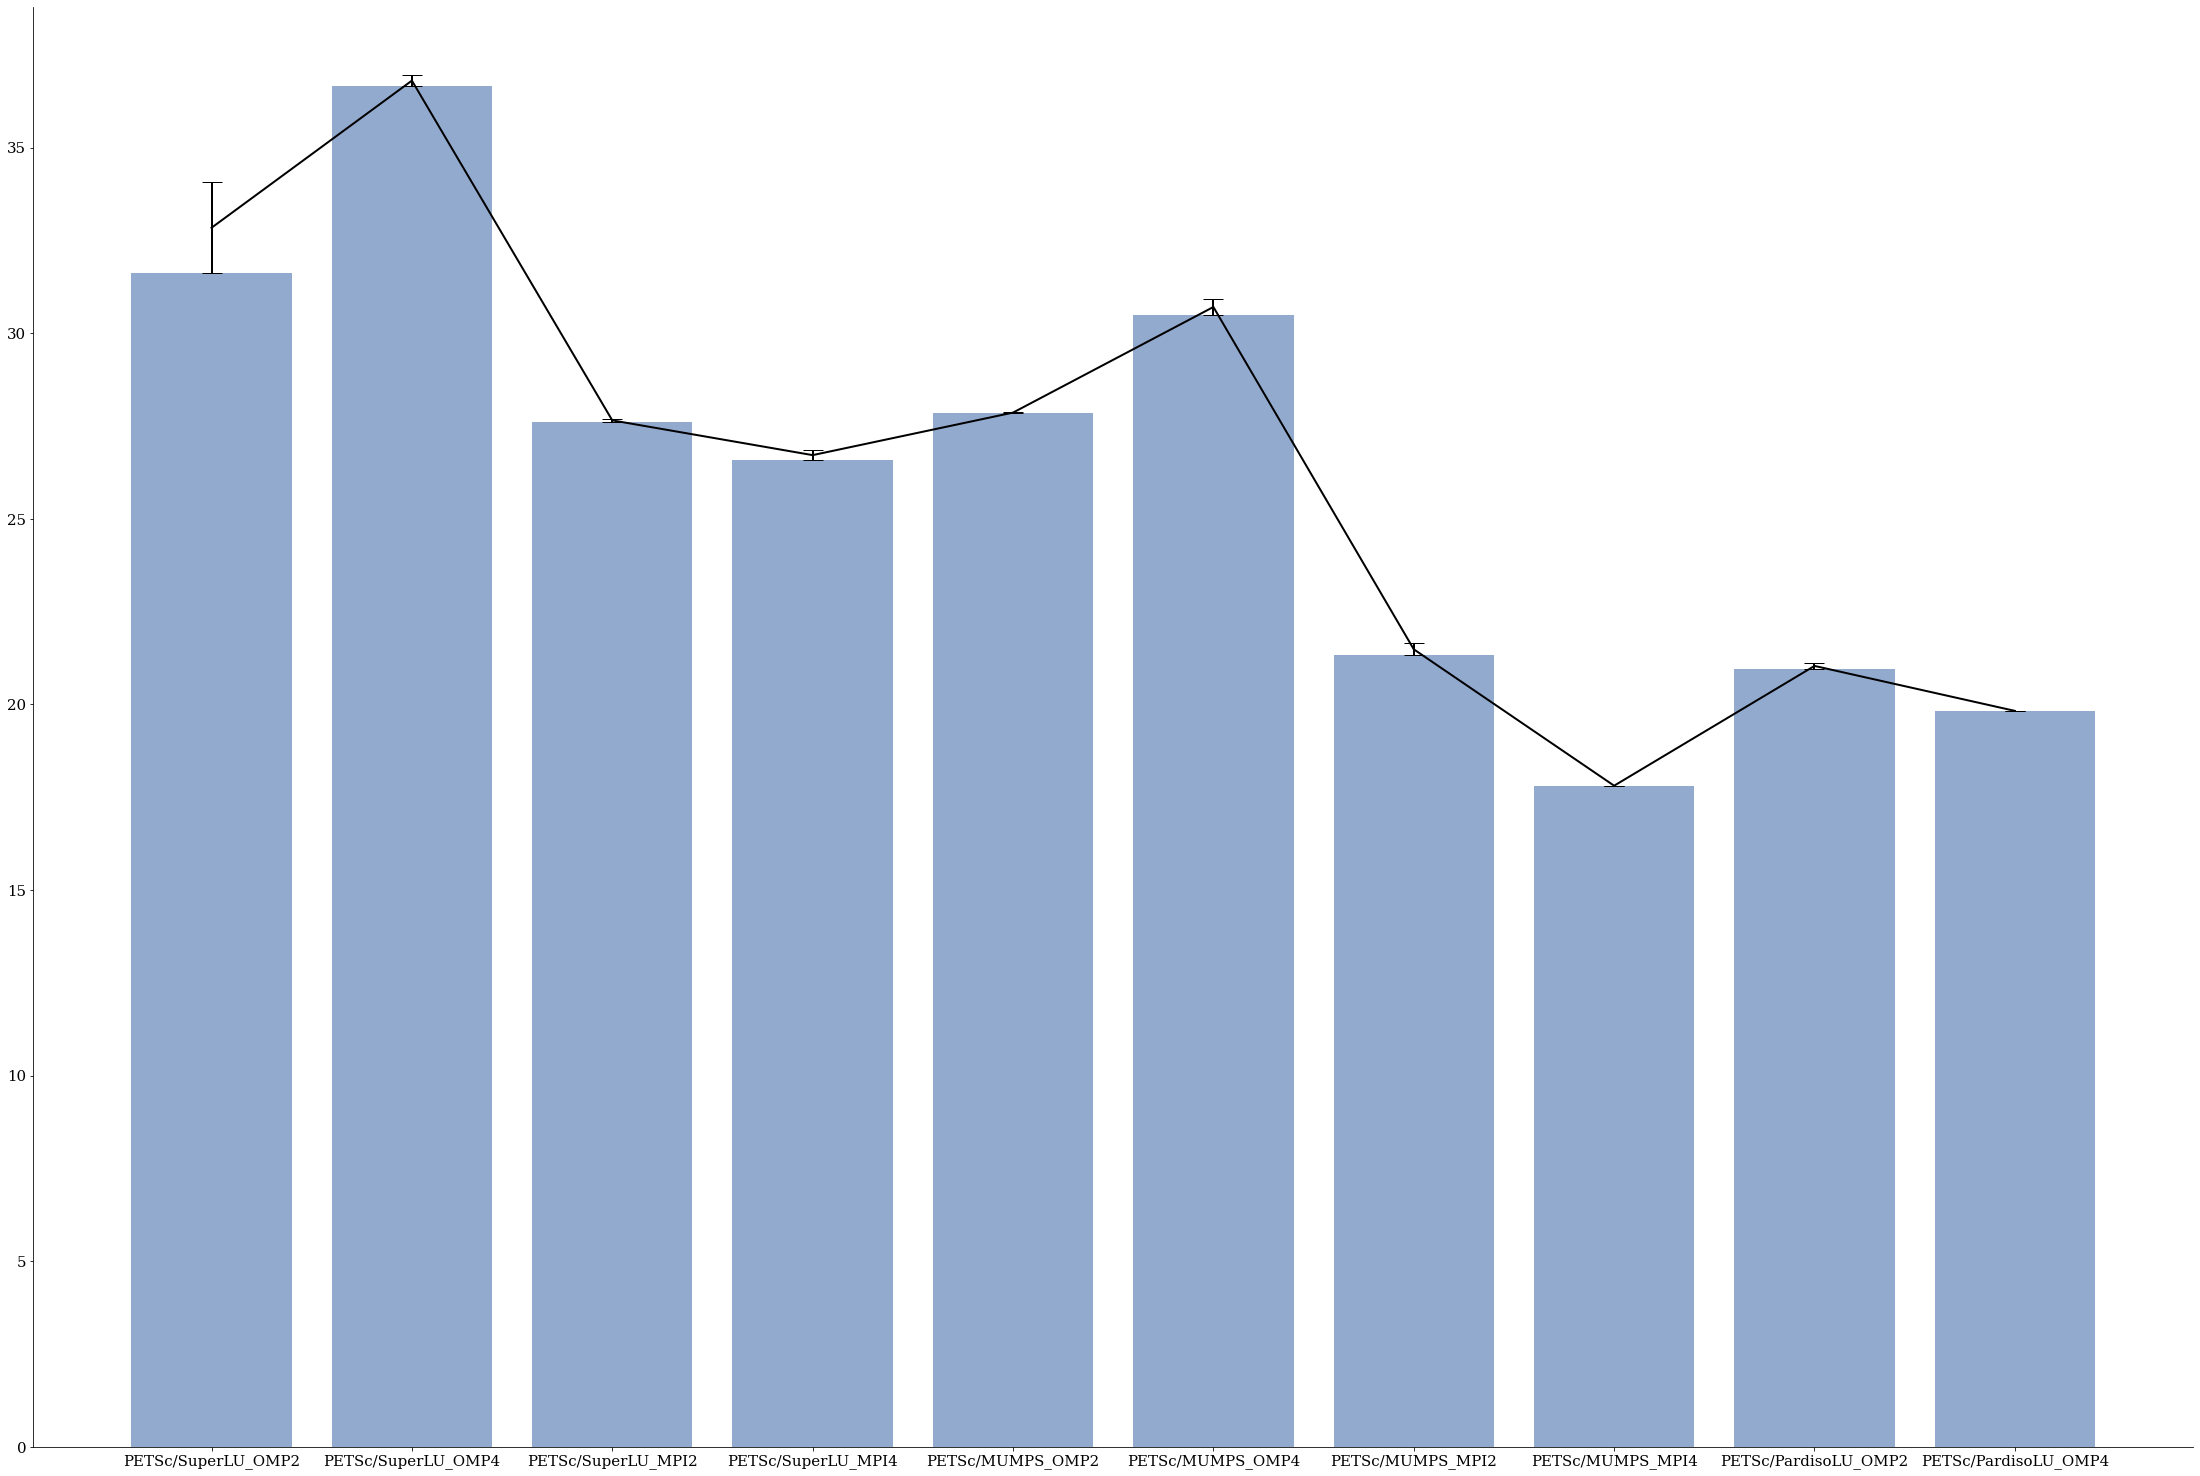

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 20
fig = plt.figure()
plt.rcParams.update({'font.size': 15})
ax = fig.add_axes([0,0,1,1])
ax.bar(solvers_ext,[np.min(exec_time[solver]) for solver in solvers_ext], alpha=0.6)
plt.errorbar(solvers_ext, [np.mean(exec_time[solver]) for solver in solvers_ext], yerr=[np.std(exec_time[solver]) for solver in solvers_ext], color="black", capsize=10)
plt.show()

In [12]:
[np.sum(exec_time[solver])/runs for solver in solvers_ext]

[32.841792821884155,
 36.80568790435791,
 27.653622031211853,
 26.716994285583496,
 27.862619876861572,
 30.707714796066284,
 21.487252116203308,
 17.811673164367676,
 21.038614988327026,
 19.8275785446167]